# Test Model

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## generating synthetic data

In [4]:
F_true = np.array([[0.01, 0.04, 0.95], [0.3, 0.4, 0.3], [0.7, 0.2, 0.1]])
X_true = np.array([[1, 2, 0.1, 5], [1, 0.2, 2, 3], [9, 0.2, 2, 4]], dtype=float)
X_true = X_true / X_true.sum(axis=1, keepdims=True)
np.dot(F_true, X_true)

array([[0.57018618, 0.01625946, 0.13802668, 0.27552768],
       [0.27918475, 0.09092467, 0.17220965, 0.45768094],
       [0.17788834, 0.18060691, 0.086316  , 0.55518875]])

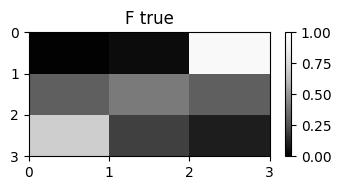

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2))
r = ax.pcolormesh(F_true, vmin=0, vmax=1, cmap="Greys_r")
plt.colorbar(r, ax=ax)
ax.invert_yaxis()
ax.set_title("F true")
fig.tight_layout()

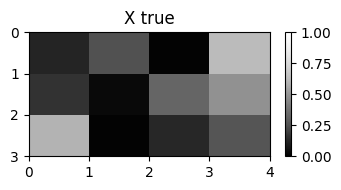

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2))
r = ax.pcolormesh(X_true, vmin=0, vmax=1, cmap="Greys_r")
plt.colorbar(r, ax=ax)
ax.invert_yaxis()
ax.set_title("X true")
fig.tight_layout()

In [7]:
ncom, nchem = X_true.shape
L = [10, 20, 30]
data = [None] * len(L)
for i in range(ncom):
    data[i] = np.zeros((L[i], nchem))
    Y = data[i]
    for j in range(Y.shape[0]):
        f = F_true[i, :] + (F_true[i, :] * 0.02 * np.random.randn(3))
        f /= f.sum()
        x = X_true + 0.02 * np.random.randn(*X_true.shape)
        x /= x.sum(axis=1, keepdims=True)
        m = np.dot(f, x)
        Y[j, :] = m
    Y[Y < 0] = 1e-3
    Y /= Y.sum(axis=1, keepdims=True)

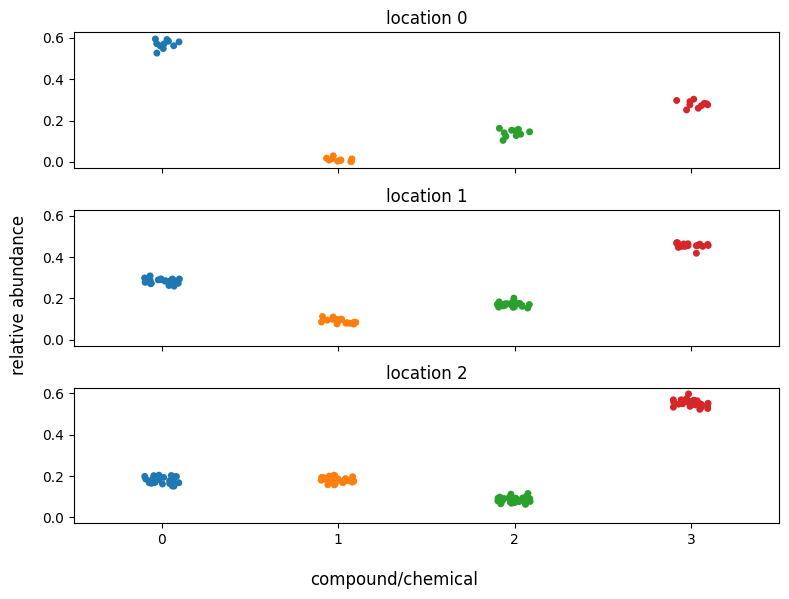

In [8]:
fig, axs = plt.subplots(ncom, 1, figsize=(8, 6), sharex=True, sharey=True)
for i in range(ncom):
    sns.stripplot(data[i], ax=axs[i])
    axs[i].set_title(f"location {i}")
fig.supxlabel("compound/chemical")
fig.supylabel("relative abundance")
fig.tight_layout()

## model definition

In [9]:
with pm.Model() as model:

    F = pm.Dirichlet("F", a=np.full(3, 1), shape=(3, 3))

    X_ = pm.Triangular("X_", lower=X_true * 0.90, c=X_true, upper=X_true * 1.1)
    X = pm.Deterministic("X", X_ / pm.math.sum(X_, axis=1, keepdims=True))

    M = pm.Deterministic("M", pm.math.dot(F, X))

    for i in range(ncom):
        sigma = pm.Beta(f"sigma {i}", alpha=1, beta=25, shape=4)
        pm.Normal(f"obs {i}", mu=M[i, :], sigma=sigma, observed=data[i])

    prior = pm.sample_prior_predictive(samples=16_000)

Sampling: [F, X_, obs 0, obs 1, obs 2, sigma 0, sigma 1, sigma 2]


## prior predictive checks

<Figure size 640x480 with 0 Axes>

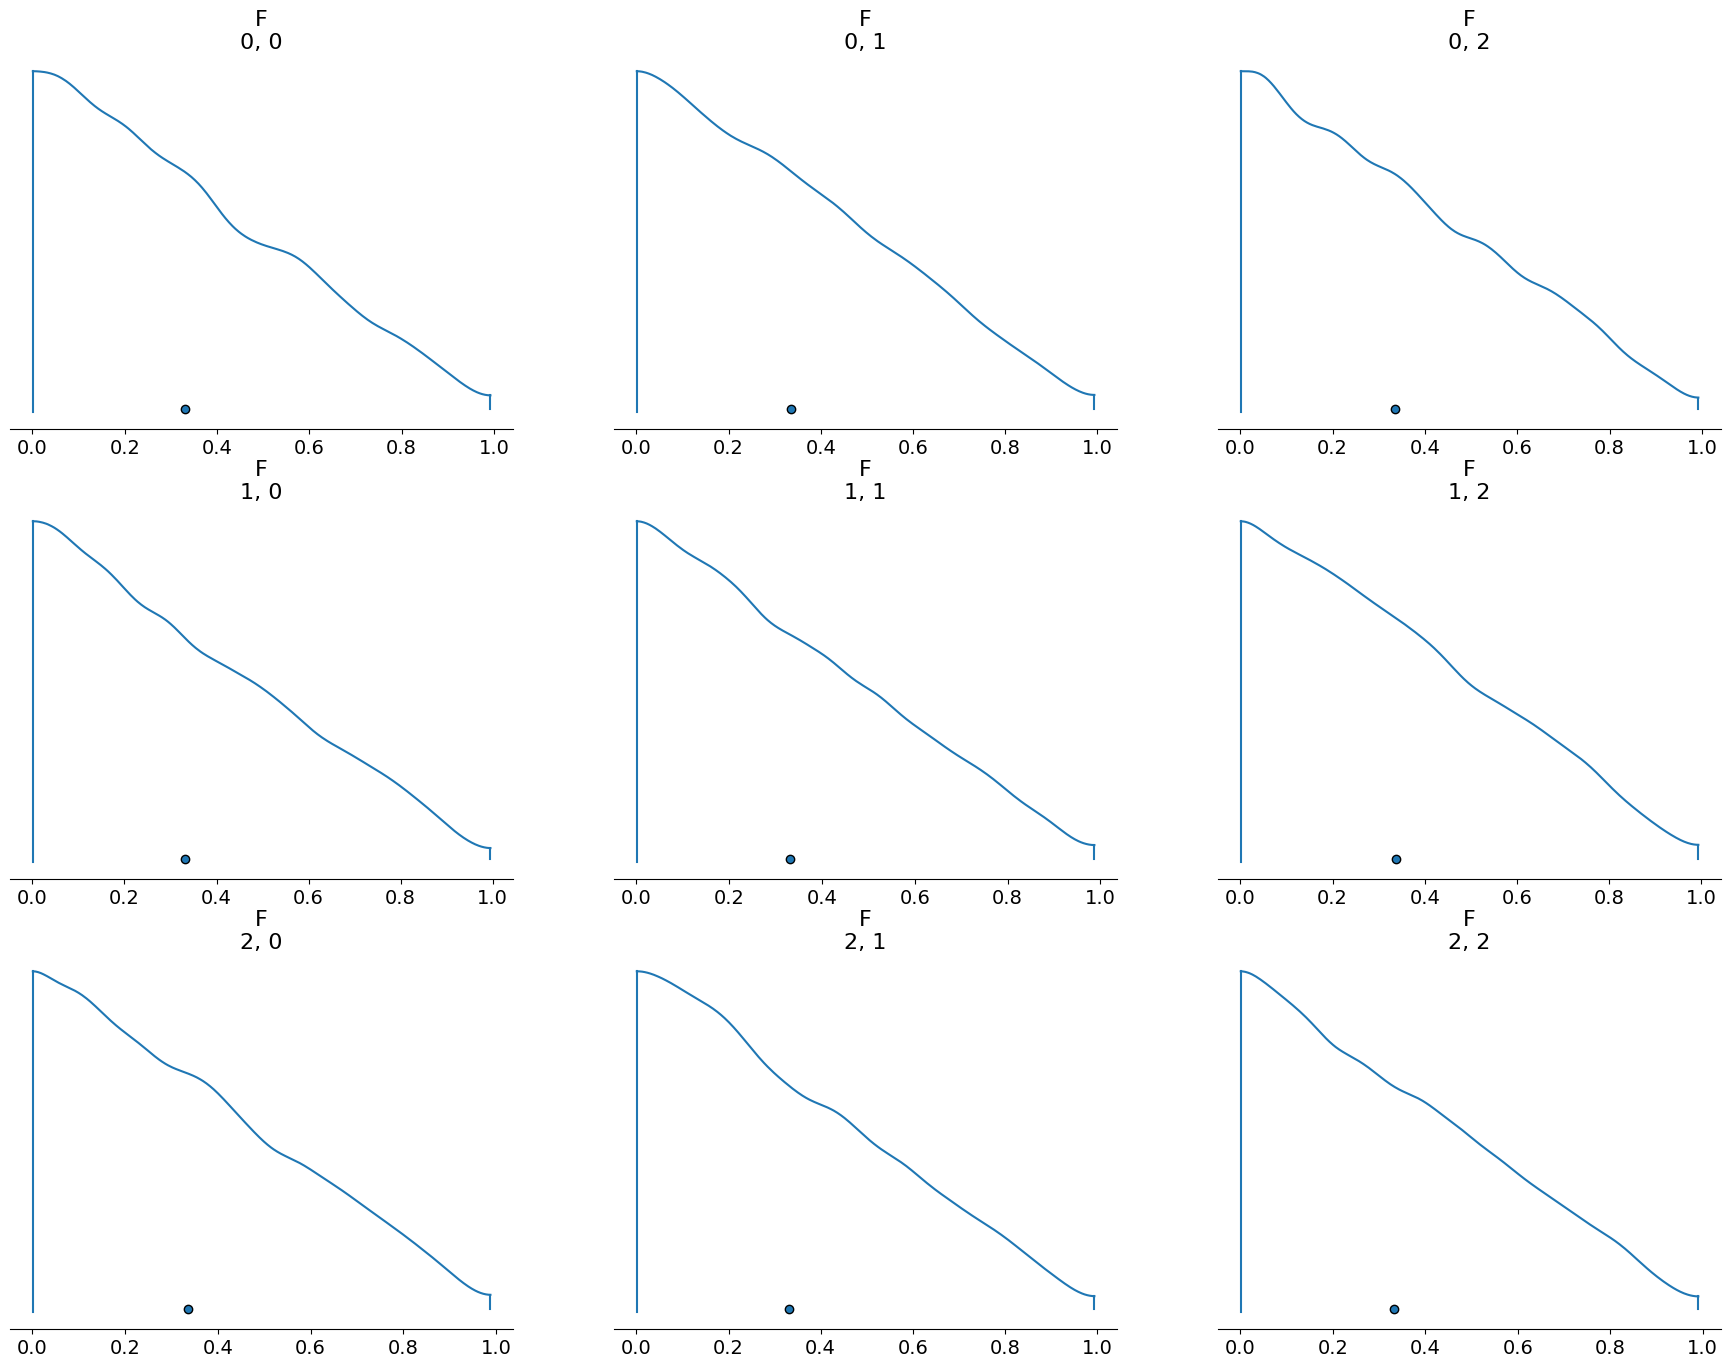

In [10]:
fig = plt.figure()
az.plot_density(prior.prior, var_names=["F"], hdi_prob=1, grid=(3, 3))
fig.tight_layout()

<Figure size 640x480 with 0 Axes>

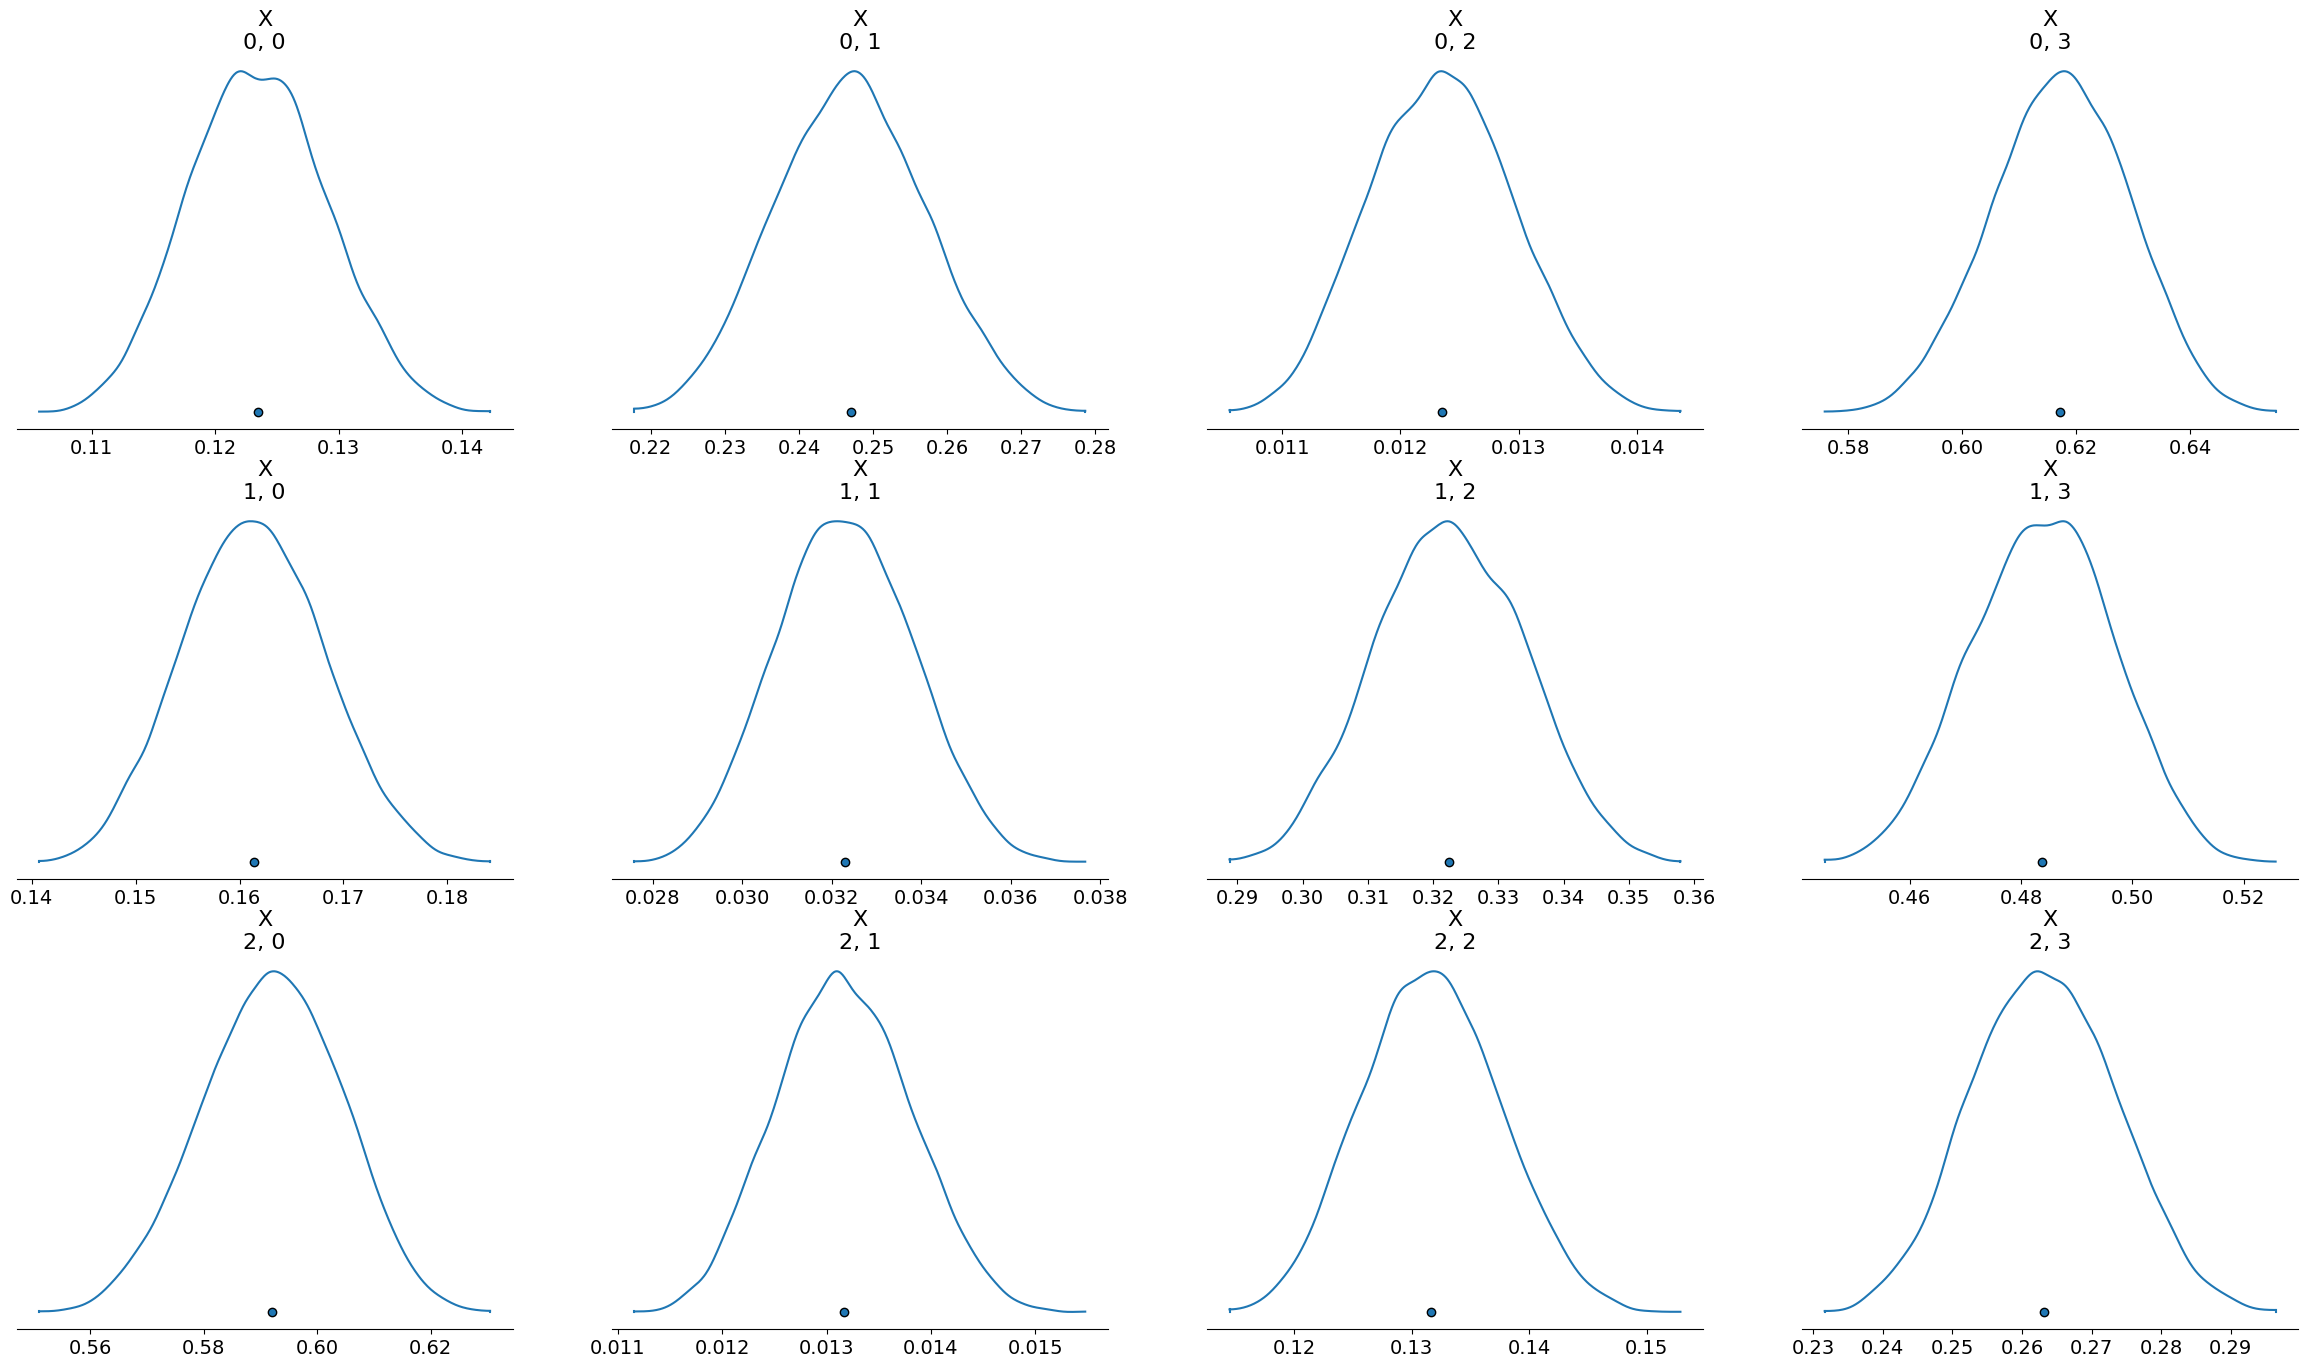

In [11]:
fig = plt.figure()
az.plot_density(prior.prior, var_names=["X"], hdi_prob=1, grid=(3, 4))
fig.tight_layout()

<Figure size 640x480 with 0 Axes>

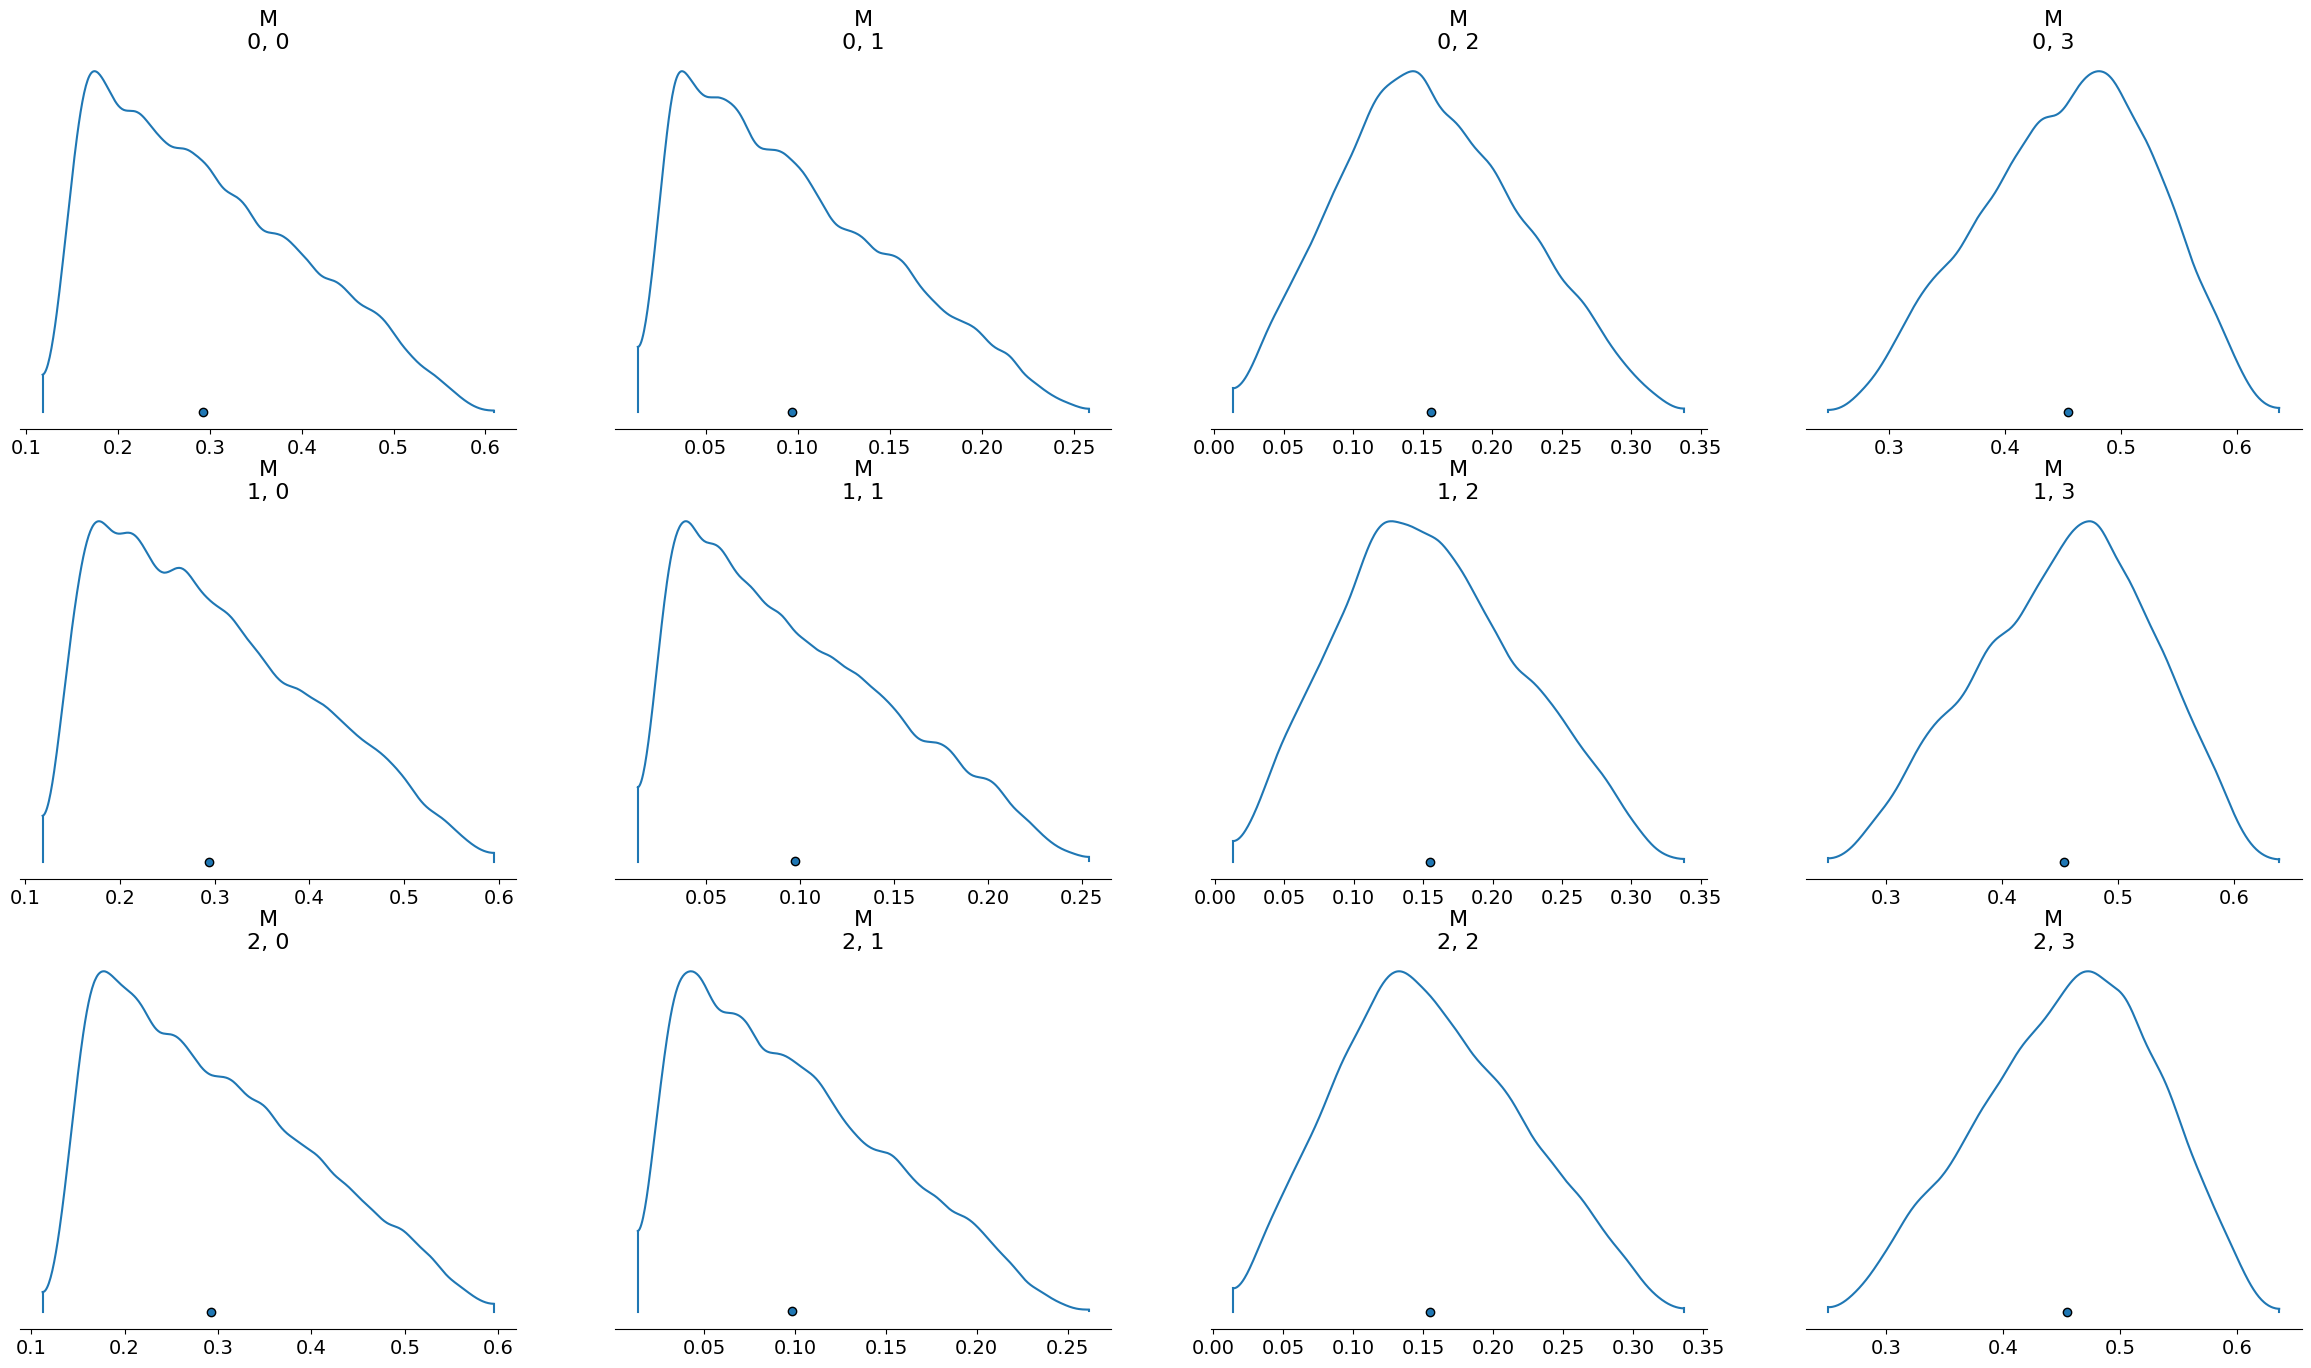

In [12]:
fig = plt.figure()
az.plot_density(prior.prior, var_names=["M"], hdi_prob=1, grid=(3, 4))
fig.tight_layout()

## posterior sampling

In [13]:
with model:
    post = pm.sample(cores=8, chains=8, tune=2_000, draws=4_000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [F, X_, sigma 0, sigma 1, sigma 2]


Sampling 8 chains for 2_000 tune and 4_000 draw iterations (16_000 + 32_000 draws total) took 75 seconds.


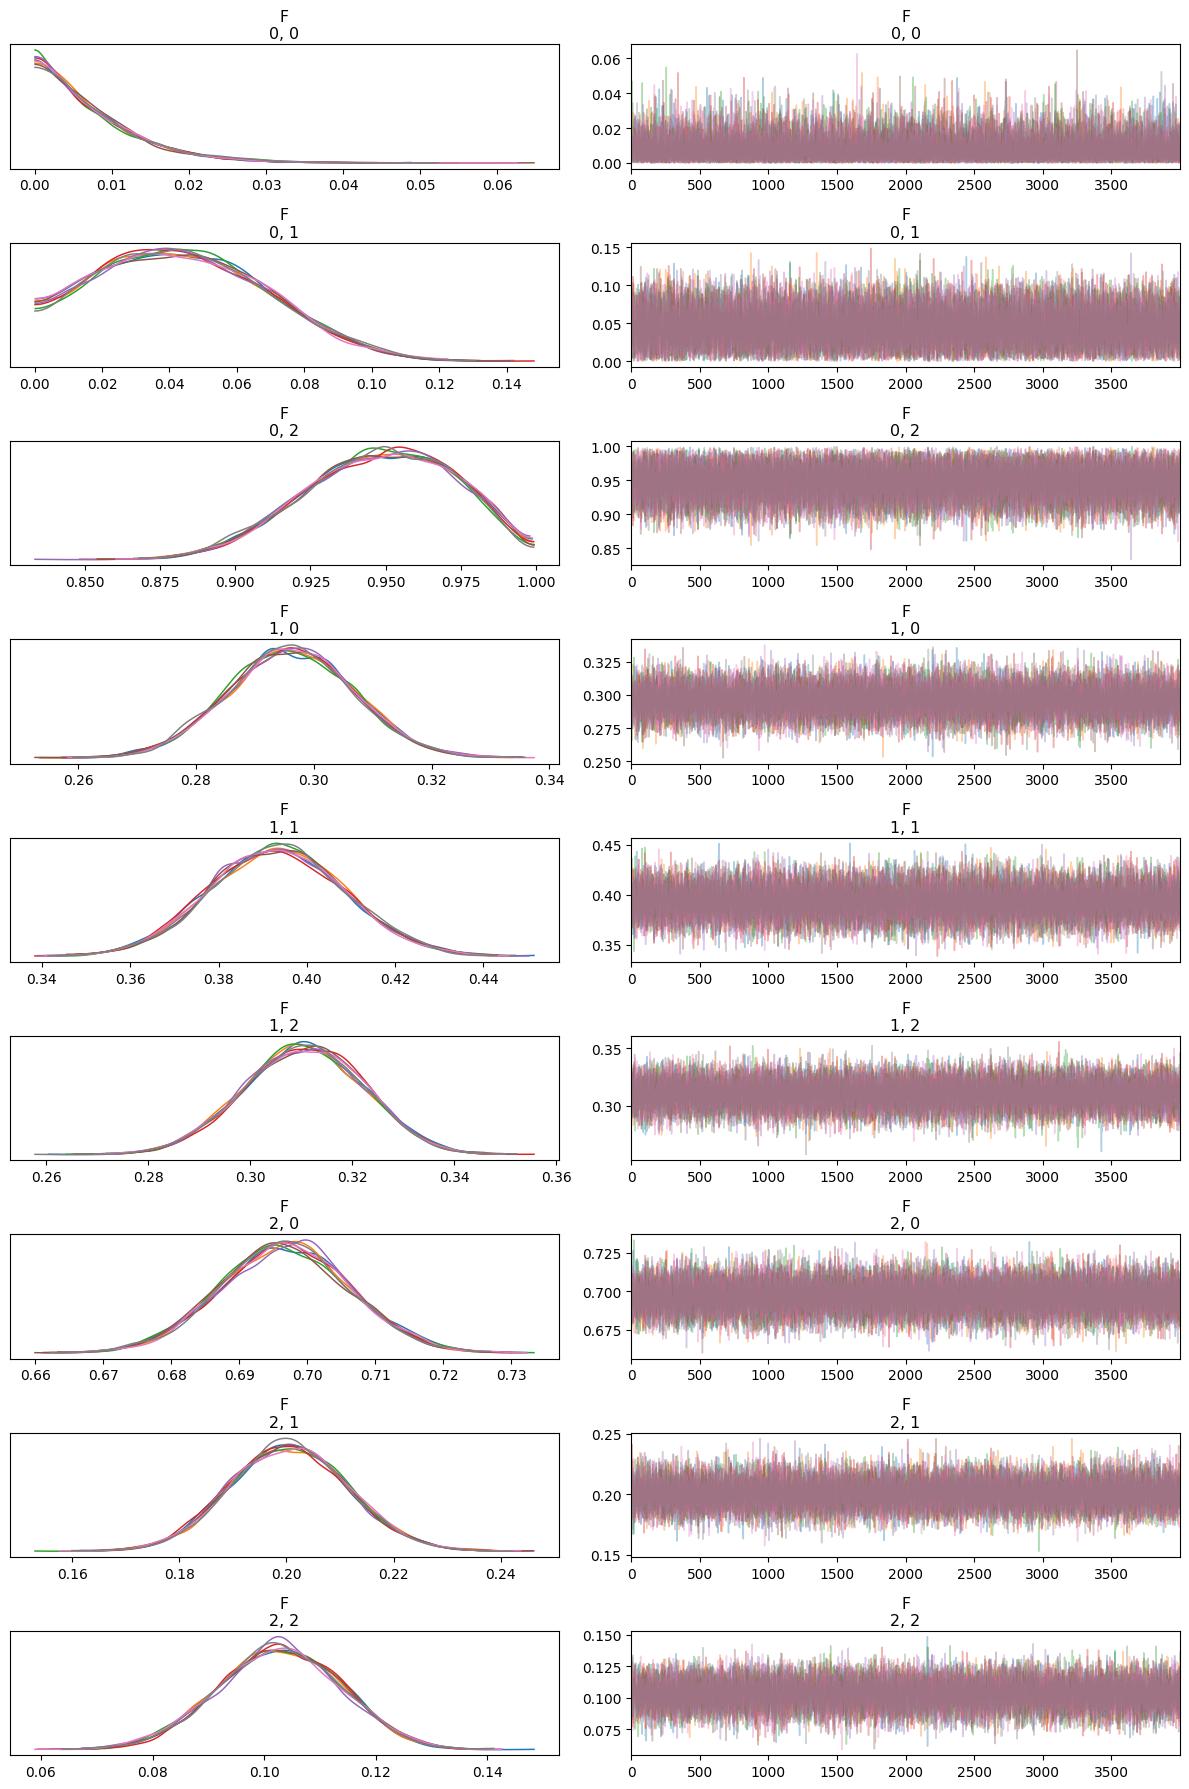

In [14]:
az.plot_trace(post, var_names=["F"], compact=False)
plt.gcf().tight_layout()

## posterior summary & analysis

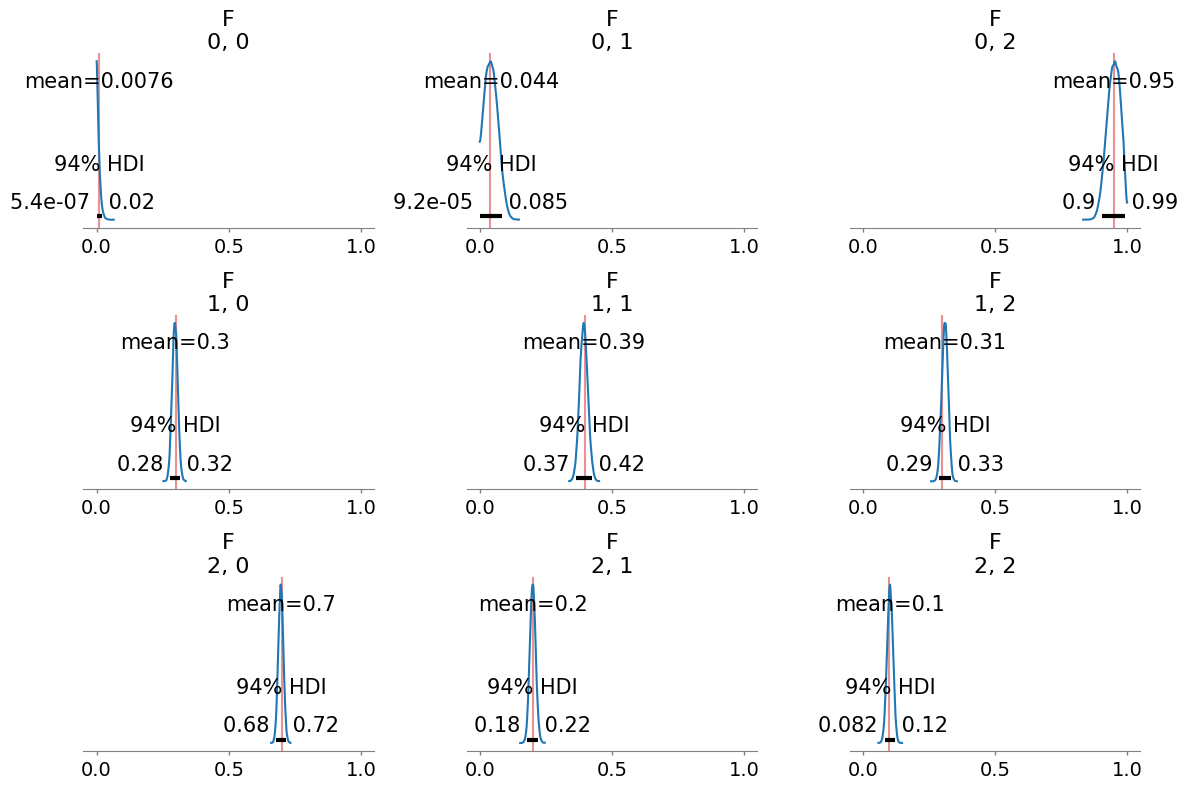

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), sharex=True)
az.plot_posterior(post, var_names=["F"], ax=axs)
for ax, f in zip(axs.flatten(), F_true.flatten()):
    ax.axvline(f, color="C3", alpha=0.5, zorder=-1)
fig.tight_layout()

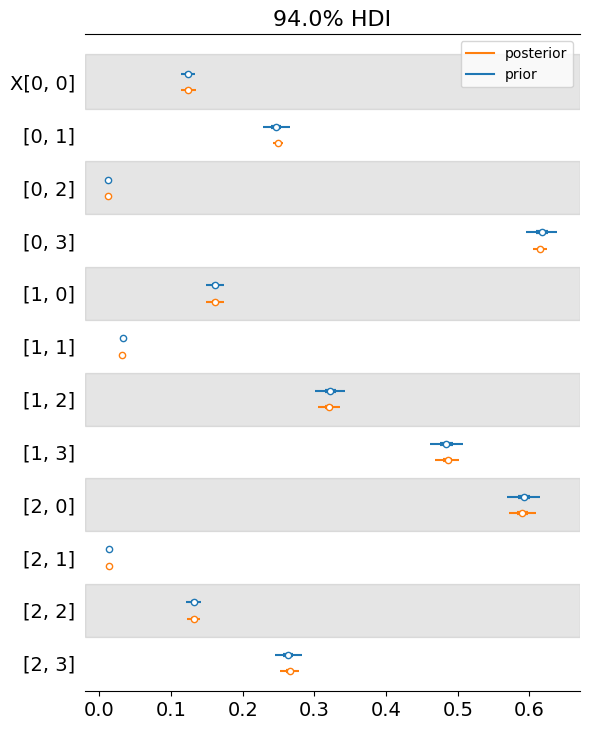

In [16]:
az.plot_forest(
    [prior.prior, post.posterior],
    var_names="X",
    model_names=["prior", "posterior"],
    combined=True,
)
plt.gcf().tight_layout()

/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


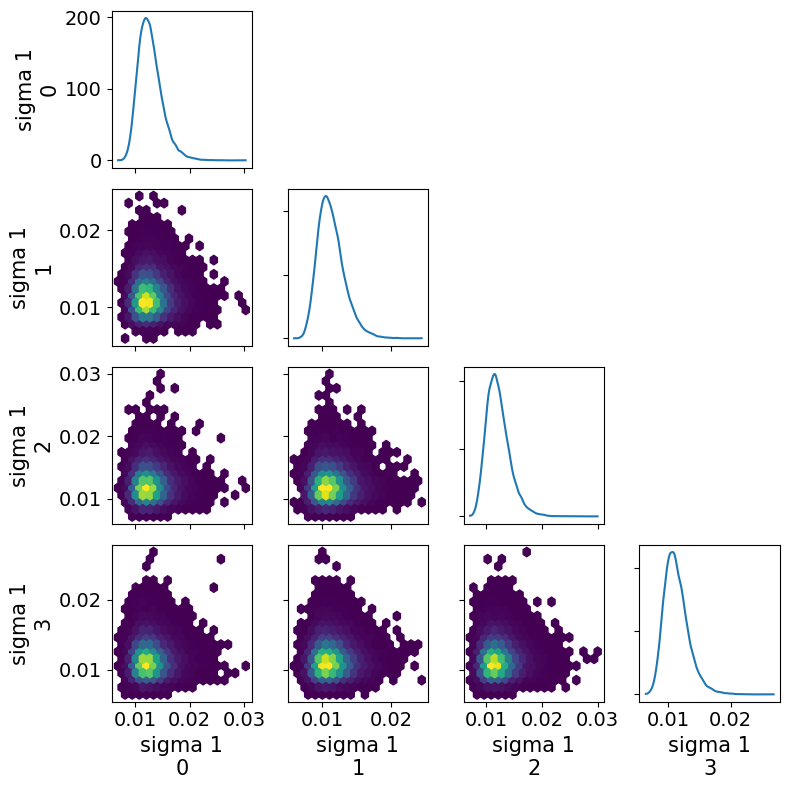

In [19]:
az.plot_pair(
    post,
    var_names="sigma 1",
    divergences=True,
    marginals=True,
    figsize=(8, 8),
    kind="hexbin",
)
plt.gcf().tight_layout()

In [20]:
with model:
    ppc = pm.sample_posterior_predictive(post)

Sampling: [obs 0, obs 1, obs 2]


/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/markbaum/Library/Caches/pypoetry/virtualenvs/cascadia-margin-lipids-mMstoHi0-py3.11/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


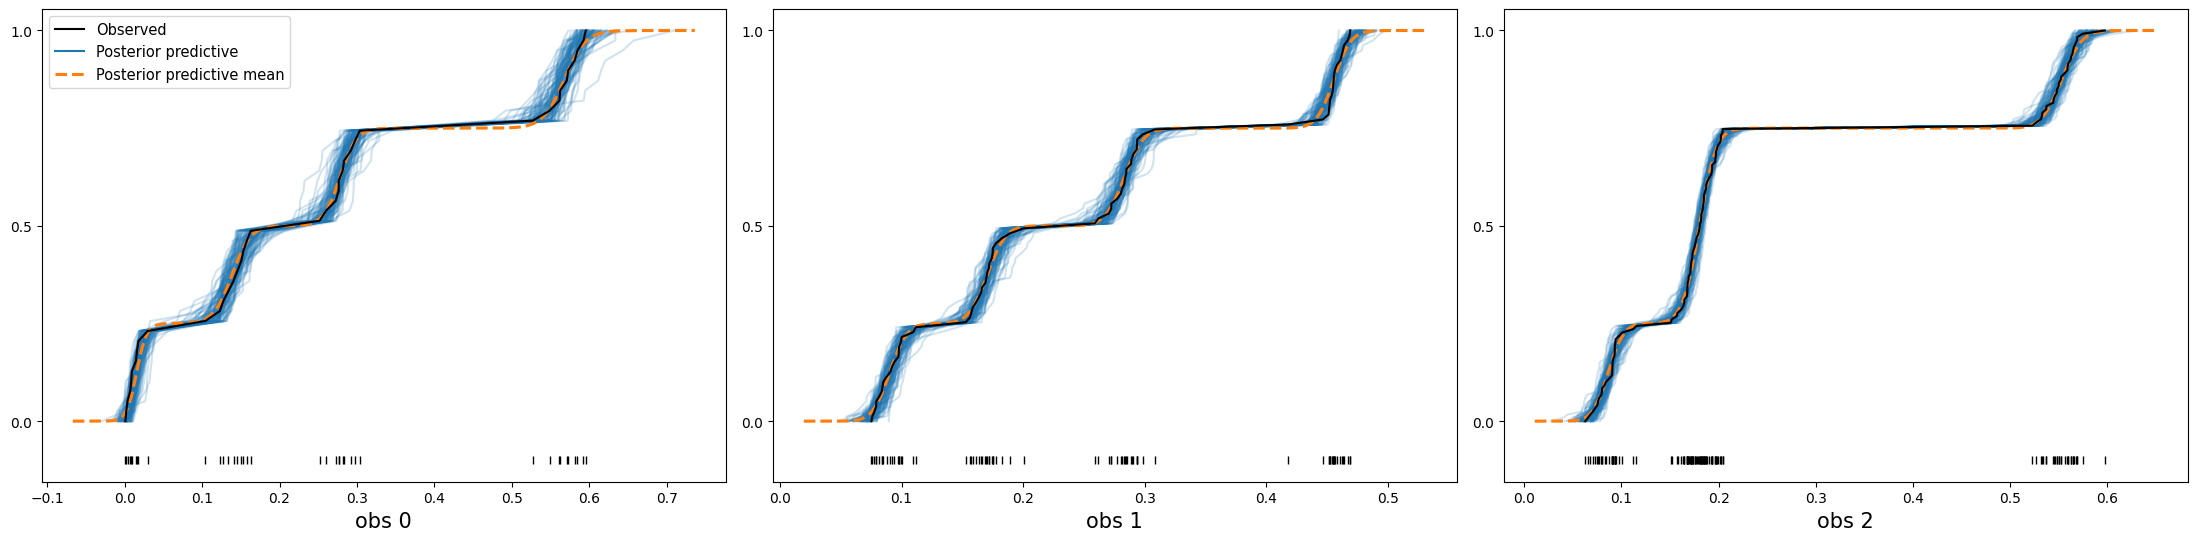

In [22]:
az.plot_ppc(ppc, num_pp_samples=100, kind="cumulative", observed_rug=True)
plt.gcf().tight_layout()